In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Inspect column names and types for measurement table
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Inspect column name and types for station table
columns = inspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
(latest_date,) = last_data_point
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
last_year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_data_df = pd.DataFrame(last_year_data).set_index("date")

# Drop any null values
last_year_data_df = last_year_data_df.dropna(how="any")

# Sort the dataframe by date
#last_year_data_df = last_year_data_df.sort_values("date", ascending=True)

# View dataframe
last_year_data_df

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]),
 <a list of 11 Text major ticklabel objects>)

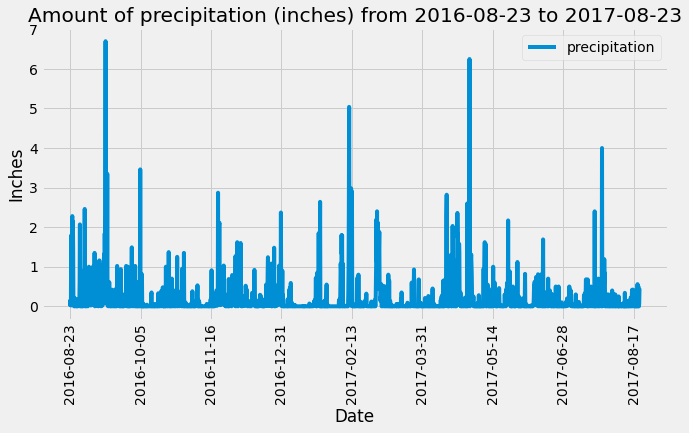

In [79]:
# Use Pandas Plotting with Matplotlib to plot the data
last_year_prcp_chart = last_year_data_df.plot(figsize=(10, 5))

# Add legend
last_year_prcp_chart.legend(["precipitation"], loc="upper right")

# Add title and labels
last_year_prcp_chart.set_title(f"Amount of precipitation (inches) from {date_year_ago} to {latest_date}")
last_year_prcp_chart.set_xlabel("Date")
last_year_prcp_chart.set_ylabel("Inches")

# Add grid
last_year_prcp_chart.grid(b = True)

plt.xticks(rotation=90)

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_data_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station.station).count()
print(f'There are {stations_count} stations available.')

There are 9 stations available.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Query most active station
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

# Unpack from tuple
(most_active_station, ) = most_active_station

# Calculate lowest, highest and average temp
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station)

for min_temp, max_temp, avg_temp in temperature_stats:
    print(f'The lowest temperature recorded for {most_active_station} is {min_temp}.')
    print(f'The highest temperature recorded for {most_active_station} is {max_temp}.')
    print(f'The average temperature recorded for {most_active_station} is {round(avg_temp, 2)}.')

The lowest temperature recorded for USC00519281 is 54.0.
The highest temperature recorded for USC00519281 is 85.0.
The average temperature recorded for USC00519281 is 71.66.


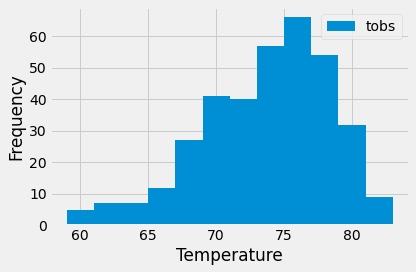

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find last data point date for most active station
last_data_point = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == most_active_station).first()

# Convert result to string and formatting
(latest_date,) = last_data_point
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()

# Find date 1 year from last entry
date_year_ago = latest_date - dt.timedelta(days=365)

# Query most active station's temperature observation data for the year
most_active_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= date_year_ago)

# Save results as a dataframe
most_active_tobs_df = pd.DataFrame(most_active_tobs, columns=["Date", "tobs"])
most_active_tobs_df

# Visualise data
most_active_tobs_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.grid(True)
plt.tight_layout()

In [19]:
most_active_tobs_df

,Date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0
...,...,...
352,2017-08-14,77.0
353,2017-08-15,77.0
354,2017-08-16,76.0
355,2017-08-17,76.0


## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = "2016-12-25"
trip_end_date = "2017-01-05"

# Apply function to chosen trip dates
temps_list = calc_temps(trip_start_date, trip_end_date)

# Convert numpy arrayto list
temps_list = list(np.ravel(temps_list))

# Print results
print(temps_list)

[62.0, 70.23611111111111, 78.0]


Text(0, 0.5, 'Temp(F)')

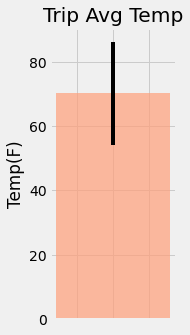

In [59]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = temps_list[0]
avg_temp = temps_list[1]
max_temp = temps_list[2]
yerr = max_temp - min_temp

plt.figure(figsize=(2,5))
plt.bar(x=1, height=avg_temp, color="lightsalmon", alpha=0.7, yerr=yerr)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False
)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")

In [60]:
measurement_columns = inspector.get_columns('Measurement')
station_columns = inspector.get_columns('Station')

print("Columns in Measurement table")
print("-----------------------------------------")
for column in measurement_columns:
    print(column["name"], column["type"])
print("-----------------------------------------")
print("Columns in Station table")
print("-----------------------------------------")
for column in station_columns:
    print(column["name"], column["type"])

Columns in Measurement table
-----------------------------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------------------------------------
Columns in Station table
-----------------------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [66]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
trip_total_rainfall = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start_date).\
    filter(Measurement.date <= trip_end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for record in trip_total_rainfall:
    print(record)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 6.94)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.71)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.54)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.2500000000000002)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.84)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.21000000000000002)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)


In [67]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = "2016-12-25"
trip_end_date = "2017-01-05"
# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
